In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import rasterio as rio
from rasterio import CRS
from rasterio.transform import from_origin
from rasterio.plot import show
import tensorflow as tf
import keras
from keras import models, layers, utils, backend as K

from functions import one_hot_encode, preprocess, binary_classification_preprocess, multiclass_classification_preprocess, nn_regression_preprocess
from functions import linear_regression, logistic_regression, decision_tree, random_forest, neural_net
from neural_net_functions import DNN_functional, get_compiled_model, dense_block, run_training, neural_net, nn_regression_preprocess

In [2]:
# reads a portion of raster
def read_image_chunk(path, xgeo, ygeo, width, height):
    with rio.open(path) as ds:
        row, col = ds.index(xgeo, ygeo)
        data = ds.read(window=rio.windows.Window(col, row, width, height))
    return data

In [13]:
# reads all files and adds each band/window of 200x200 to images array
paths = ['data/geoKARMA_h24v13_landsat_2019.tif',
    'data/geoKARMA_h24v13_aspect_2019.tif',
    'data/geoKARMA_h24v13_dem_2019.tif',
    'data/geoKARMA_h24v13_posidex_2019.tif', 
    'data/geoKARMA_h24v13_wetlands_2019.tif',
    'data/geoKARMA_h24v13_impervious_2019.tif']
training_dataset = './data/geoKARMA_h24v13_pixelbased_dataset.csv'


# opens and read paths into one array images
def open_paths():
    with rio.open(paths[1]) as src0:
        profile = src0.profile

    datas = {path.split('_')[-2]: read_image_chunk(path, 1034415, 1364805, 201, 201) for path in paths}
    images = pd.DataFrame(np.concatenate([datas[key] for key in ['landsat', 'dem', 'aspect', 'posidex', 'wetlands', 'impervious']]).reshape(11, -1).transpose(), columns=['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 
                                                                                                        'landsat_6', 'dem_1', 'aspect_1', 'posidex_1', 'wetlands_1', 'impervious_1'])
    print("shape in open_paths", images.shape)
    return profile, images

# define features based on regression model
def get_features(pred_function):
    if pred_function == linear_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1']
    if pred_function == logistic_regression:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']
    if pred_function == decision_tree or pred_function == random_forest:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6']

    if pred_function == neural_net:
        features = ['landsat_1', 'landsat_2', 'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',  
        'aspect_1_0', 'aspect_1_1', 'aspect_1_2', 'aspect_1_3', 'aspect_1_4',
        'aspect_1_5', 'aspect_1_6', 'aspect_1_7', 'aspect_1_8', 'aspect_1_9', 
        'aspect_1_10', 'aspect_1_11', 'aspect_1_12', 'aspect_1_13', 'aspect_1_14',
        'aspect_1_15', 'aspect_1_16', 'aspect_1_17','aspect_1_18', 
        'wetlands_1_0', 'wetlands_1_2', 'wetlands_1_3', 'wetlands_1_4', 
        'wetlands_1_5', 'wetlands_1_6', 'wetlands_1_7', 'wetlands_1_8',
        'dem_1', 'posidex_1', 'NDVI']
    return features

def get_input_df(pred_function, features):
    profile, images = open_paths()
    # returns input dataframe holding features
    if pred_function == neural_net: data = nn_regression_preprocess(images)[features]
    else: data = preprocess(images)[features]
    print("shape in get_input_df", data.shape)
    return profile, data

def get_predictions(input_df, pred_function):
    if pred_function == neural_net:
        model = tf.keras.models.load_model("./data/model.h5", compile=False)
        impervious_df = model.predict_on_batch(input_df)
    elif pred_function == decision_tree:
        impervious_df = pred_function(training_dataset, 5).predict(input_df)
    else:
        impervious_df = pred_function(training_dataset).predict(input_df)
    # df = model.predict(input_df)
    return impervious_df

def write_raster(profile, array, new_name):
    with rio.open(new_name, 'w', **profile) as output:
        output.write(array)

def map_impervious(pred_function, new_name):
    # define features and input
    features = get_features(pred_function)
    profile, df = get_input_df(pred_function, features)

    #get predictions
    impervious_df = get_predictions(df, pred_function)

    # reshapes output into 200x200 array
    impervious_output = np.array(impervious_df).reshape(1, 200, 200)
    if pred_function == neural_net:
        impervious_output = np.transpose(impervious_output, (0,2,1))
    
    #write new raster
    write_raster(profile, impervious_output, new_name)
    

In [14]:
# options for model: linear_regression, logistic_regression, decision_tree, neural_net

map_impervious(logistic_regression, 'logistic_test2.tif')

shape in open_paths (40000, 11)
shape in get_input_df (40000, 6)


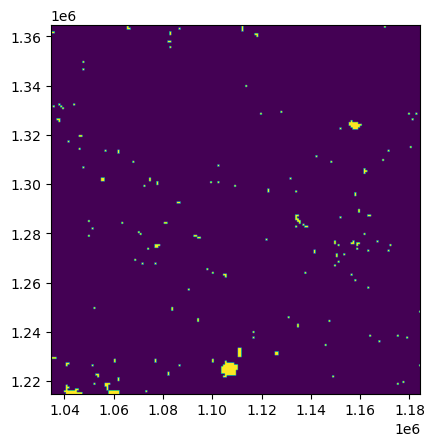

<Axes: >

In [15]:
raster = rio.open('logistic_test2.tif')
show(raster)